In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

In [2]:
import cytnx
import numpy as np
import scipy as sp
from scipy import linalg
import matplotlib.pyplot as plt

# Time evolve an MPS by time-evolution block-decimation (TEBD)
#### Consider a Hamiltonian that contains only two-site terms
#### $$ \hat{H} = \sum_{i=1}^{N-1} \hat{\mathcal{H}}_{i,i+1}. $$
#### The time-evolution operator $e^{-i\delta_t\hat{H}}$ for a small time step $\delta_t$ can be approximately decomposed to
#### $$ e^{-i\delta_t\hat{H}} \approx
        \left[ e^{-i\delta_t\hat{\mathcal{H}}_{1,2}} e^{-i\delta_t\hat{\mathcal{H}}_{2,3}} \cdots e^{-i\delta_t\hat{\mathcal{H}}_{N-1,N}} \right]
        \left[e^{-i\delta_t\hat{\mathcal{H}}_{N-1,N}} \cdots e^{-i\delta_t\hat{\mathcal{H}}_{2,3}} e^{-i\delta_t\hat{\mathcal{H}}_{1,2}} \right]
        + \mathcal{O}(\delta_t^3),$$
#### where each $e^{-i\delta_t\hat{\mathcal{H}}_{i,i+1}}$ is a two-site operator.


## 1. Define the time-evolution operators

### 1.1 Define operators
#### $$ \hat{S}^{z}=\frac{1}{2}\left[\begin{array}{cc}
1 & 0\\
0 & -1
\end{array}\right]
, \qquad
\hat{S}^{x}=\frac{1}{2}\left[\begin{array}{cc}
0 & 1\\
1 & 0
\end{array}\right]
, \qquad
\hat{I}=\left[\begin{array}{cc}
1 & 0\\
0 & 1
\end{array}\right]
$$

In [3]:
Sx = 2*cytnx.physics.spin(0.5,'x').real()      # Sx
Sz = 2*cytnx.physics.spin(0.5,'z').real()      # Sz
I = cytnx.eye(2)                               # Identity operator

### 1.2 Define time-evolution operator $e^{-i\delta_t\hat{\mathcal{H}}_{i,i+1}}$

#### We consider transverse-field Ising model
#### $$ \begin{aligned}
H &= -J\sum_{i=1}^{N-1} \hat{S}^x_i\hat{S}^x_{i+1} - h_x\sum_{i=1}^N \hat{S}^z_i\\
&= \sum_{i=1}^{N-1} \hat{\mathcal{H}}_{i,i+1},
\end{aligned}$$
#### where $$ \mathcal{\hat{H}}_{i,i+1}=-J\hat{S}_{i}^{x}\hat{S}_{i+1}^{x}-h_{x}\begin{cases}
\hat{S}_{i}^{z} & ,i\neq N-1\\
\left(\hat{S}_{i}^{z}+\hat{S}_{i+1}^{z}\right) & ,i=N-1.
\end{cases}$$
#### The operator $e^{-i\delta_t\hat{\mathcal{H}}_{i,i+1}}$ can be constructed as follows.

In [4]:
# Define time-evolution (two-site) gates
def get_gates (Nsites, dt, J, hz, imag=False):
    if not imag:
        dt *= 1j
    
    # Define two-site operators
    Sxx = cytnx.linalg.Kron(Sx,Sx)                             # Sx.Sx
    Sz1 = cytnx.linalg.Kron(Sz,I)                              # Sz.I
    Sz2 = cytnx.linalg.Kron(Sz,I) + cytnx.linalg.Kron(I,Sz)    # Sz.Sz
    
    gates = []
    for i in range(Nsites-1):
        # Define two-site Hamiltonian H_{i,i+1}
        if i != Nsites-2:
            H = -hz*Sz1 - J*Sxx                          # Not the last link
        else:
            H = -hz*Sz2 - J*Sxx                          # The last link
        # Compute exp(H_{i,i+1})
        expH = sp.linalg.expm (-dt*H.numpy())         # Do the exp(-i*dt*H) by first convert H to a numpy array
        expH = cytnx.from_numpy(expH)                    # Convert exp(-i*dt*H) to a Cytnx matrix
        expH.reshape_(2,2,2,2)                           # Reshape it to a two-site gate (with 4 indices)
        expH = cytnx.UniTensor (expH, rowrank=2)         # Convert it to a UniTensor
        gates.append (expH)                              # Store the gate
    return gates

### 1.3 Define the operation of applying a gate

In [5]:
def evolve_psi (expH, psi):
    # Define the network for the contraction
    anet = cytnx.Network()
    anet.FromString(["expH: 0,1;-4,-5",
                     "psi: 2,0;1,3",
                     "TOUT: 2,-4;-5,3"])

    anet.PutUniTensors(["expH","psi"], [expH, psi])
    lbl = psi.labels()
    evolved_psi = anet.Launch()
    evolved_psi.set_labels(lbl)
    return evolved_psi

## 2. Initialize MPS

### 2.1 Initialize MPS as a product state
### $$ |\psi\rangle = |\uparrow\uparrow\uparrow\uparrow\cdots\downarrow\downarrow\downarrow\downarrow\cdots\rangle$$

In [6]:
# Initialize MPS
def get_init_MPS (Nsites):
    d = 2                                          # Physical dimension
    psi = [None for i in range(Nsites)]
    for i in range(Nsites):
        A = cytnx.zeros([1,d,1])
        if i < Nsites//2:
            A[0,1,0] = 1
        else:
            A[0,0,0] = 1
        psi[i] = cytnx.UniTensor (A, rowrank=2)
        psi[i].set_labels([2*i,2*i+1,2*i+2])
    return psi

## 3. Define functions for measurements

### 3.1 On-site measurements
<img src="figures/one_site_mea.png" alt="drawing" width="500"/>

In [7]:
# Measure the on-site operator <op>
# The input MPS tensor <A> must be the orthogonality-center tensor
def measure_onsite (A, op):
    Op = cytnx.UniTensor (op, rowrank=1)

    anet = cytnx.Network()
    anet.FromString(["A: 1,2;3",
                     "Z: 2;4",
                     "Aconj: 1,4;3",
                     "TOUT:;"])
    anet.PutUniTensors (["Z","A","Aconj"],[Op, A, A.Conj()])
    obs = anet.Launch().get_block().item()
    if type(obs) == complex:
        obs = obs.real
    return obs

### 3.2 Two-site measurements
<img src="figures/two_site_mea.png" alt="drawing" width="600"/>

In [8]:
# Measure the on-site operator <op>
# One of the input MPS tensor <A1> or <A2> must be the orthogonality-center tensor
def measure_twosite (A1, A2, op):
    Op = cytnx.UniTensor (op, rowrank=1)

    anet = cytnx.Network()
    anet.FromString(["AA: 1,2;3,4",\
                     "O: 2,3;5,6",\
                     "AA_Conj: 1,5;6,4",\
                     "TOUT:;"])
    AA = cytnx.Contract(A1,A2)
    AA_Conj = cytnx.Contract(A1.Conj(),A2.Conj())
    anet.PutUniTensors(["AA","O","AA_Conj"],[AA, op, AA_Conj])
    obs = anet.Launch().get_block().real().item()
    
    anet = cytnx.Network()
    anet.FromString(["AA: 1,2;3,4",\
                     "AA_Conj: 1,2;3,4",\
                     "TOUT:;"])
    anet.PutUniTensors(["AA", "AA_Conj"],[AA, AA_Conj])
    AAnorm = anet.Launch().get_block().item()
    
    obs /= AAnorm # for safety, while AAnorm should be ~1
    if type(obs) == complex:
        obs = obs.real
    return obs

### 3.3 Global measurement $\langle\psi|\hat{H}|\psi\rangle$
<img src="figures/total_mea.png" alt="drawing" width="500"/>

In [9]:
# Measure <psi|H|psi>, where psi and H are an MPS and an MPO
# A: An array of MPS tensors
# M: A MPO tensor
def getTotalE (A, M):
    D_MPO = M.shape()[0]                                        # MPO bond dimension
    L = cytnx.UniTensor (cytnx.zeros([D_MPO,1,1]), rowrank=1)   # Left boundary
    L.get_block_()[D_MPO-1,0,0] = 1.
    R0 = cytnx.UniTensor (cytnx.zeros([D_MPO,1,1]), rowrank=1)  # Right boundary
    R0.get_block_()[0,0,0] = 1.

    anet = cytnx.Network()
    anet.FromString(["L: -2;-1,-3",
                     "A: -1,-4;1",
                     "M: -2,0;-4,-5",
                     "A_Conj: -3,-5;2",
                     "TOUT: 0;1,2"])
    # Contract the tensors from left to right
    for p in range(Nsites):
        A[p].set_rowrank(2)
        anet.PutUniTensors(["L","A","A_Conj","M"],[L,A[p],A[p].Conj(),M])
        L = anet.Launch()
    # Contract with the right boundary tensor to get the energy
    anet = cytnx.Network()
    anet.FromString(["L: -2;-1,-3",
                     "R0: -2;-1,-3",
                     "TOUT: ;"])
    anet.PutUniTensors(["L","R0"],[L,R0])
    E = anet.Launch().get_block().item()
    if type(E) == complex:
        E = E.real
    return E

### 3.4 Define Hamiltonian MPO
#### (Just for measuring energy)

In [10]:
# Define TFIM MPO
def TFIM_MPO_tensor (J, hz, hx):
    d = 2                                      # Physical dimension
    dM = 3                                     # MPO bond dimension
    M = cytnx.zeros([dM, dM, d, d])
    M[0,0] = I
    M[2,2] = I
    M[1,0] = Sx
    M[2,1] = -J*Sx
    M[2,0] = -hz*Sz - hx*Sx
    M = cytnx.UniTensor (M, rowrank=2)
    return M

## 4. Define TEBD loop

#### (Right to left)
<img src="figures/tebd_sweep.png" alt="drawing" width="700"/>

In [11]:
def tebd (psi, J, hz, dt, steps, maxdim, cutoff, imag_time=False):
    # Parameters
    # psi:        Initial MPS
    # J:          Sx.Sx coupling
    # hz:         Transverse field
    # dt:         Time step
    # steps:      Number of time steps
    # maxdim:     Maximal kept dimension when doing SVD
    # cutoff:     Cutoff for the singular values when doing SVD
    # imag_time:  Real or imaginary time evolution

    # Define the bonds for left-to-right and right-to-left sweeps
    sweeps_bonds = [range(Nsites-1), range(Nsites-2,-1,-1)]

    # Get the time-evolution gates
    expHs = get_gates (Nsites, dt, J, hz, imag=imag_time)

    # Make MPO tensor (for measuring the total energy)
    M = TFIM_MPO_tensor (J, hz, hx=0)

    # To store the on-site observables
    szs = np.full ((steps,Nsites),np.nan)
    sxs = np.full ((steps,Nsites),np.nan)
    maxdims = np.full (steps,np.nan)
    
    # TEBD sweeps
    for step in range(steps):
        print ('step',step,end="")
        for lr in [0,1]:
            for p in sweeps_bonds[lr]:
                
                # Compute psi for the bond
                AA = cytnx.Contract (psi[p], psi[p+1])
                AA.set_rowrank(2);
                
                # Apply gate to psi
                evolved_psi = evolve_psi (expHs[p], AA)

                # SVD and truncate psi to MPS tensors
                s, psi[p], psi[p+1] = cytnx.linalg.Svd_truncate (evolved_psi, keepdim=maxdim, err=cutoff)
                # Normalize the singular values
                s = s/s.get_block_().Norm().item()
                
                # Absorb the singular-value tensor into the left/right site
                if lr == 0:
                    psi[p+1] = cytnx.Contract (s,psi[p+1])
                else:
                    psi[p] = cytnx.Contract (psi[p],s)

                # Measure
                if lr == 0 and p == Nsites-2:
                    A = psi[Nsites-1]
                    A.set_rowrank(2)
                    szs[step,Nsites-1] = measure_onsite (A, Sz)
                    sxs[step,Nsites-1] = measure_onsite (A, Sx)
                if lr == 1:
                    szs[step,p] = measure_onsite (psi[p], Sz)
                    sxs[step,p] = measure_onsite (psi[p], Sx)
        # Compute the maximal bond dimension for the MPS
        maxm = 0
        for p in range(Nsites):
            maxm = max(psi[p].shape()[0], psi[p].shape()[2], maxm)
        maxdims[step] = maxm
        print (', max dim='+str(maxm),end="")

        # Compute the total energy
        print (", total E=", getTotalE (psi,M))
    return psi, szs, sxs, maxdims

## 5. Compute the ground state by imaginary time evolution
#### (Compare with DMRG)

In [12]:
Nsites = 20                                   # Number of sites
dt = 0.2

psi = get_init_MPS (Nsites)
psi, szs, sxs, dims = tebd (psi, J=1, hz=0.5, dt=dt, steps=10, maxdim=200, cutoff=1e-6, imag_time=True)

step 0, max dim=4, total E= -14.65136692039136
step 1, max dim=6, total E= -19.27787639443965
step 2, max dim=8, total E= -20.037975377301095
step 3, max dim=8, total E= -20.24846136247697
step 4, max dim=8, total E= -20.331062249025674
step 5, max dim=10, total E= -20.36651299168352
step 6, max dim=10, total E= -20.381894148058397
step 7, max dim=10, total E= -20.388551151835586
step 8, max dim=10, total E= -20.391423926156904
step 9, max dim=10, total E= -20.392660897800905


## 6. Compute time-evolved state by real-time evolution

### 6.1 Compute time evolution

In [13]:
dt = 0.05

psi = get_init_MPS (Nsites)
psi, szs, sxs, dims = tebd (psi, J=1, hz=10, dt=dt, steps=40, maxdim=200, cutoff=1e-6)

step 0, max dim=4, total E= 0.010538643249410985
step 1, max dim=5, total E= 0.005818830222917799
step 2, max dim=6, total E= 0.0009888972272806655
step 3, max dim=6, total E= 0.014210994577475572
step 4, max dim=8, total E= 8.417728880817698e-05
step 5, max dim=8, total E= 0.0046127573480553375
step 6, max dim=8, total E= 0.015485286529531777
step 7, max dim=9, total E= -0.00546776484497122
step 8, max dim=10, total E= 0.010940924800875886
step 9, max dim=10, total E= 0.012469978322312138
step 10, max dim=11, total E= -0.007734318955160617
step 11, max dim=12, total E= 0.017197387799049654
step 12, max dim=13, total E= 0.0059688191796067065
step 13, max dim=15, total E= -0.004858858073826414
step 14, max dim=15, total E= 0.019611247909470025
step 15, max dim=15, total E= -0.00020005343992656258
step 16, max dim=16, total E= 0.0012470038218572671
step 17, max dim=16, total E= 0.017241943805274912
step 18, max dim=18, total E= -0.0028169702964426797
step 19, max dim=19, total E= 0.00683

### 6.2 Plot the results

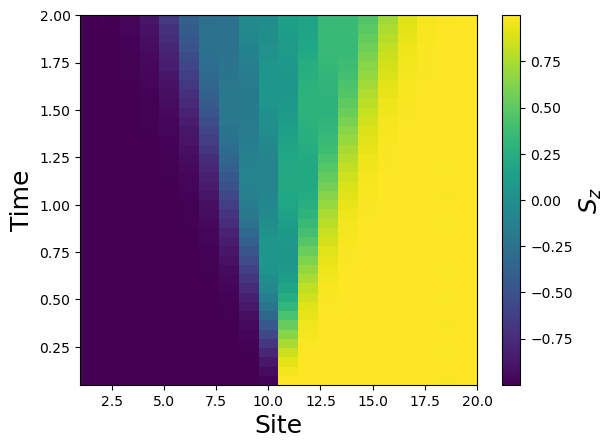

In [14]:
# Funtion for printing an observable as a function of time and site
def plot_prof (ax, data, dt, label=''):
    Nstep, L = np.shape(data)
    sc = ax.imshow (data, origin='lower', extent=[1, L, dt, Nstep*dt], aspect='auto')
    cb = plt.colorbar (sc)
    ax.set_xlabel ('Site', fontsize=18)
    ax.set_ylabel ('Time', fontsize=18)
    cb.ax.set_ylabel (label, fontsize=18)
f,ax = plt.subplots()
plot_prof (ax, szs, dt, label='$S_z$')
plt.show()